In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import healpy as hp
from rubin_scheduler.scheduler.utils import get_current_footprint

In [2]:
# on the RSP, no tokenfile is needed - skip kwarg. 
# otherwise, point to your own RSP token file.
# !pip install git+https://github.com/lsst-sims/rubin_nights.git --no-deps if needed
from rubin_nights import connections
endpoints = connections.get_clients(tokenfile='/Users/lynnej/.lsst/usdf_rsp')
consdb = endpoints['consdb']

# # OR you could just use the consdb client, 
# # if running in env with lsst-summit packages at USDF 
# efd = 'usdf_efd' 
# if 'usdf' in os.getenv("EXTERNAL_INSTANCE_URL", ""):
#     os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/data/rubin/shared/rubin_sim_data"
#     os.environ["no_proxy"] += ",.consdb"ed: 
# from lsst.summit.utils import ConsDbClient
# consdb = ConsDbClient()

In [3]:
instrument = 'lsstcomcam'
query = f"select * from cdb_{instrument}.visit1  where (science_program = 'BLOCK-320' or science_program = 'PP-SURVEY')"
visits = consdb.query(query)

In [4]:
# from leanne's notebook 

# 47_Tuc	47 Tucanae Globular Cluster	6.022329	-72.081444
# 1	ECDFS	Extended Chandra Deep Field South	53.125	-28.1
# 2	EDFS_comcam	Rubin SV Euclid Deep Field South	59.1004	-48.73
# 4	Fornax_dSph	Fornax Dwarf Spheroidal Galaxy	39.9971	-34.4492
# 0	Rubin_SV_095_-25	Rubin SV Low Galactic Latitude Field	95.0	-25.0
# 3	Rubin_SV_38_7	Rubin SV Low Ecliptic Latitude Field	37.86	6.98
# 6	Seagull	Seagull Nebula	106.23	-10.51
# 7	slew_icrs	Engineering pointing	53.17	-28.07


In [5]:
dp1_targets = ['47_Tuc', 'ECDFS', 'EDFS_comcam', 'Fornax_dSph', 'Rubin_SV_095_-25', 'Rubin_SV_38_7', 'Seagull', 'slew_icrs']

s = visits.query("target_name in (@dp1_targets)")
print(len(visits), len(s))

1992 1906


In [6]:
df = s.groupby(['target_name', 'band']).agg({'s_ra': 'mean', 's_dec': 'mean', 'band': 'count'})
df.rename(columns={'band': 'count'}, inplace=True)
df = df.reset_index()
df['s_ra'] = np.round(df['s_ra'], 2)
df['s_dec'] = np.round(df['s_dec'], 2)
df = df.pivot(index=['target_name', 's_ra', 's_dec'], columns=['band']).fillna(0)
df = df.droplevel(level=0, axis=1)
df = df.astype({'u': int, 'g': int, 'r': int, 'i': int, 'z': int, 'y': int})

In [7]:
centers = s.groupby('target_name').agg({'s_ra': 'mean', 's_dec': 'mean'}).round(2)
centers = centers.rename(columns={'s_ra': 'ra', 's_dec': 'dec'})
counts = s.groupby(['target_name', 'band']).agg({'band': 'count'}).rename(columns={'band': 'count'})
counts = counts.reset_index().pivot(index=['target_name'], columns=['band']).fillna(0)
counts = counts.droplevel(level=0, axis=1)
counts = counts.astype({'u': int, 'g': int, 'r': int, 'i': int, 'z': int, 'y': int})
join = pd.merge(centers, counts, left_index=True, right_index=True)
join['total'] = join['u'] + join['g'] + join['r'] + join['i'] + join['z'] + join['y']
join = join.sort_values(by='dec')
join[['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'y', 'total']]

,ra,dec,u,g,r,i,z,y,total
target_name,,,,,,,,,
47_Tuc,6.09,-72.09,6,10,33,19,0,5,73
EDFS_comcam,59.13,-48.74,20,61,90,42,42,20,275
Fornax_dSph,40.06,-34.45,0,5,26,13,0,0,44
ECDFS,53.15,-28.11,25,212,213,131,138,30,749
slew_icrs,52.50,-26.67,28,18,39,46,41,0,172
Rubin_SV_095_-25,95.02,-25.01,33,86,97,29,60,11,316
Seagull,106.26,-10.52,10,37,44,0,10,0,101
Rubin_SV_38_7,37.88,6.97,0,44,55,57,20,0,176


In [8]:
for b in ['u', 'g', 'r', 'i', 'z', 'y', 'total']:
    join.loc['ECDFS', b] = join.loc['ECDFS', b] + join.loc['slew_icrs', b]
    join.loc['slew_icrs', b] = 0
join = join.drop('slew_icrs')
join[['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'y', 'total']]

,ra,dec,u,g,r,i,z,y,total
target_name,,,,,,,,,
47_Tuc,6.09,-72.09,6,10,33,19,0,5,73
EDFS_comcam,59.13,-48.74,20,61,90,42,42,20,275
Fornax_dSph,40.06,-34.45,0,5,26,13,0,0,44
ECDFS,53.15,-28.11,53,230,252,177,179,30,921
Rubin_SV_095_-25,95.02,-25.01,33,86,97,29,60,11,316
Seagull,106.26,-10.52,10,37,44,0,10,0,101
Rubin_SV_38_7,37.88,6.97,0,44,55,57,20,0,176


In [9]:
# The numbers above are slightly different than those in Leanne's notebook - perhaps there are visits which did not successfully process but are counted in the consdb

# also should probably discount the fields with no target_name or for fields where there were only a few exposures

In [10]:
footprint_hp, labels = get_current_footprint(nside=64)

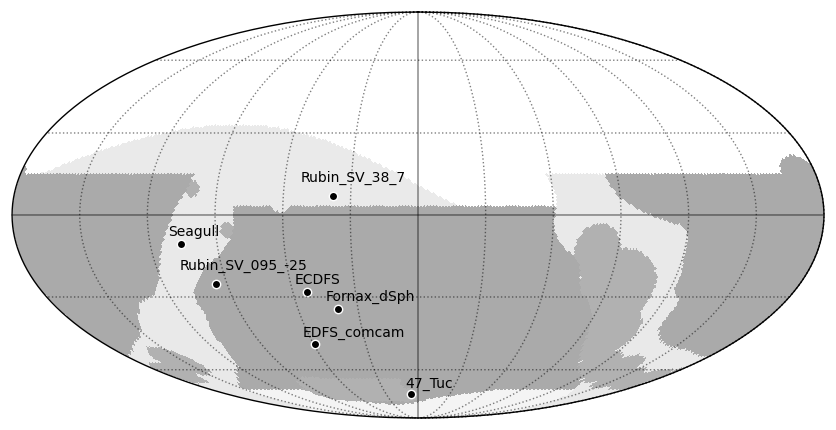

In [11]:
total_fp = np.sum([footprint_hp[b] for b in 'ugrizy'], axis=0) 
total_fp = total_fp / max(total_fp)
total_fp = np.where(total_fp == 0, np.nan, total_fp)
hp.mollview(total_fp, min=0, max=3, badcolor='white', cmap='binary', cbar=False, title='')
hp.graticule(alpha=0.5)
for counter, (i, target) in enumerate(join.iterrows()):
    sign = 2 * (counter % 2) + 1
    hp.projscatter(target.ra, target.dec, lonlat=True, facecolor='black', marker='o', edgecolors='white')
    if not target.name.startswith('slew') and not target.name.startswith('Rubin'):
        hp.projtext(target['ra'] + 5, target['dec'] + 3, target.name, lonlat=True)
    if target.name.startswith('Rubin'):
        hp.projtext(target['ra'] + 15, target['dec'] + 5, target.name, lonlat=True)

plt.savefig("dp1_fields_with_survey_fp.pdf", format='pdf')